In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

Warning: this doesn't work. This was from Donald's code that I just changed a few things

In [19]:
def generate(string): 
    a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
    b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])

    maxMats = 50
    dataPoints = 3000
    prevMat = -1
    consecutiveA = 0
    consecutiveB = 0
    mat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    


    for j in range(dataPoints):
        mat = np.array([[1,0,0],[0,1,0],[0,0,1]])
        nextMat = random.randint(0,1)
        if nextMat == 0: 
            mat = np.matmul(a, mat)
            consecutiveA = consecutiveA + 1 
            consecutiveB = 0 
            prevMat = 0
        elif nextMat == 1:
            mat = np.matmul(b, mat)
            consecutiveB = consecutiveB + 1
            consecutiveA = 0
            prevMat = 1
        numOfMatrices = random.randint(1, maxMats)
        for i in range(numOfMatrices):
            nextMat = random.randint(0,1)
            if nextMat == 0 and consecutiveA == 2: 
                map = np.matmul(b, mat)
                consecutiveB = consecutiveB + 1
                consecutiveA = 0
                prevMat = 1
            if nextMat == 1 and consecutiveB == 2:
                mat = np.matmul(a, mat)
                consecutiveA = consecutiveA + 1 
                consecutiveB = 0 
                prevMat = 0
            elif (nextMat == 0):
                mat = np.matmul(a, mat)
                consecutiveA = consecutiveA + 1 
                consecutiveB = 0 
                prevMat = 0
            elif (nextMat == 1):
                mat = np.matmul(b, mat)
                consecutiveB = consecutiveB + 1
                consecutiveA = 0
                prevMat = 1
            
        if j == 0: 
            df = pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]], columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])
        else: 
            df = pd.concat([df, pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]],columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])])
# mat[0][0] = mat[0][0]  % 7
# mat [0][1] = mat[0][1]  % 7
# mat[0][2] = mat[0][2]  % 7
# mat [1][0] = mat[1][0]  % 7
# mat [1][1] = mat[1][1]  % 7
# mat [1][1] = mat[1][1]  % 7
    df.to_csv(string, index = False)

In [20]:
# code adapted from ChatGPT

# Define your neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.step1 = nn.Linear(9, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 2, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = SimpleModel()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item

        scheduler.step()
        
        # Print the average loss for this epoch
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [21]:
generate('matrices_train.csv')
generate('matrices_test.csv')
df = pd.read_csv("matrices_train.csv")
just_input = df.drop('last', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())
desired_output = torch.tensor(df['last'].tolist(), dtype=torch.float32).long()

/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_70310/363369511.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 2.1782541275024414
Epoch [1/500], Loss: 0.7261
total loss: 2.0860018134117126
Epoch [2/500], Loss: 0.6953
total loss: 2.056920647621155
Epoch [3/500], Loss: 0.6856
total loss: 2.0182498693466187
Epoch [4/500], Loss: 0.6727
total loss: 1.9757518768310547
Epoch [5/500], Loss: 0.6586
total loss: 1.9438294768333435
Epoch [6/500], Loss: 0.6479
total loss: 1.9521604776382446
Epoch [7/500], Loss: 0.6507
total loss: 1.9633569121360779
Epoch [8/500], Loss: 0.6545
total loss: 1.9352357983589172
Epoch [9/500], Loss: 0.6451
total loss: 1.937991201877594
Epoch [10/500], Loss: 0.6460
total loss: 1.942746877670288
Epoch [11/500], Loss: 0.6476
total loss: 1.9419113397598267
Epoch [12/500], Loss: 0.6473
total loss: 1.9281423687934875
Epoch [13/500], Loss: 0.6427
total loss: 1.9201716780662537
Epoch [14/500], Loss: 0.6401
total loss: 1.9432145953178406
Epoch [15/500], Loss: 0.6477
total loss: 1.913862407207489
Epoch [16/500], Loss: 0.6380
total loss: 1.915408968925476
Epoch [17/500], Loss: 0

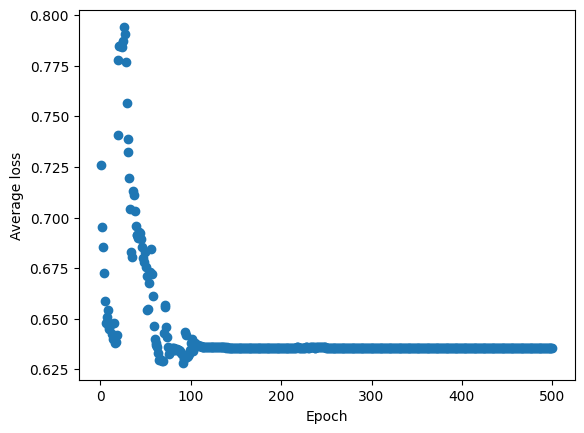

In [22]:

# Train the model
trained_model = train_model(input_data, desired_output, 500, viz_accuracy=True)


In [28]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)
    print(test_output)

    predicted_classes = torch.argmax(test_output, dim=1)
    print(predicted_classes)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)
    print(test_output_compare)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [36]:
test_df = pd.read_csv("matrices_test.csv")
just_input_test = test_df.drop('last', axis=1)
input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['last'].tolist(), dtype=torch.float32).long()

test_model(trained_model, input_data_test, desired_output)

tensor([[3.4408e-02, 9.6559e-01],
        [1.0000e+00, 3.3104e-35],
        [1.0000e+00, 0.0000e+00],
        ...,
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [3.4408e-02, 9.6559e-01]], grad_fn=<SoftmaxBackward0>)
tensor([1, 0, 0,  ..., 0, 0, 1])
tensor([1, 0, 0,  ..., 1, 1, 1], dtype=torch.int32)


/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_70310/2208809294.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.6606666445732117

torch.save()

# Using Model's results


In [33]:
# Generate random matrix in SL3Z 

x = np.array([[1,0,1],[0,-1,-1],[0,1,0]])
y = np.array([[0,1,0],[0,0,1],[1,0,0]])
z = np.array([[0,1,0],[1,0,0],[-1,-1,-1]])
a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])
mat = ([[1,0,0],[0,1,0],[0,0,1]])

aInv = np.array([[1, -4, -1],[0,-2,-1],[0,3,1]])
bInv = np.array([[1, 0, 1],[2, 1, 3],[-3,0,2]])

for i in range(500):
    coin = random.randint(0,2)
    if coin == 0: 
        mat = np.matmul(x, mat)
    elif coin == 1: 
        mat = np.matmul(y, mat)
    elif coin == 2: 
        mat = np.matmul(z, mat)


for i in range(5000):
    input_array = np.array([mat[0][0],mat[0][1], mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1], mat[2][2]] )
    input_tensor = torch.tensor([input_array], dtype=torch.float32)
    prediction = trained_model(input_tensor)

    first_coordinate = prediction[0][0].item()
    if abs(1 - first_coordinate) < abs(first_coordinate): 
        #apply a inv . 
        mat = np.matmul(aInv, mat)
    else: 
        mat = np.matmul(bInv, mat)

In [41]:
# testing out by starting with generated with our matrices 
a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])
mat = ([[1,0,0],[0,1,0],[0,0,1]])

aInv = np.array([[1, -4, -1],[0,-2,-1],[0,3,1]])
bInv = np.array([[1, 0, 1],[2, 1, 3],[-3,0,2]])

for i in range(1000):
    coin = random.randint(0,1)
    if coin == 0: 
        mat = np.matmul(a, mat)
    elif coin == 1: 
        mat = np.matmul(b, mat)


for i in range(300):
    input_array = np.array([mat[0][0],mat[0][1], mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1], mat[2][2]] )
    input_tensor = torch.tensor([input_array], dtype=torch.float32)
    prediction = trained_model(input_tensor)
    first_coordinate = prediction[0][0].item()
    print(first_coordinate)
    if abs(1 - first_coordinate) < abs(first_coordinate): 
        #apply a inv . 
        mat = np.matmul(aInv, mat)
    else: 
        mat = np.matmul(bInv, mat)
    if i == 0: 
            df = pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], round(prediction[0][0].item())]], columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])
    else: 
            df = pd.concat([df, pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], round(prediction[0][0].item())]],columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])])
    df.to_csv("Steps", index = False)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


(300, 9)


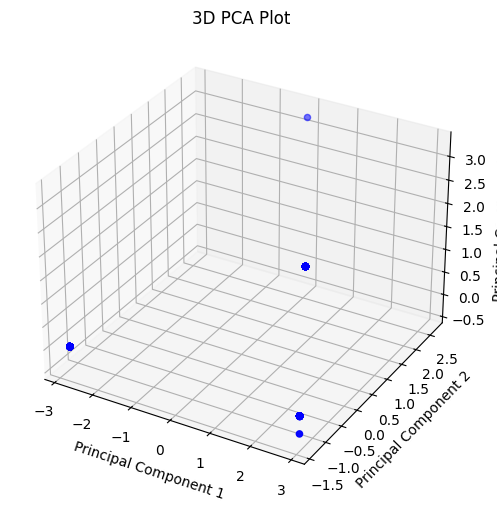

In [35]:
# trying pca 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
matrix = ['00','01','02','10','11','12','20','21','22']
x = df.loc[:, matrix].values
y = df.loc[:,['last']].values
x = StandardScaler().fit_transform(x)
print(x.shape)

#CHAT GPT

# Assuming 'x' is your original data
# PCA transformation
pca = PCA(n_components=3)
fittedData = pca.fit_transform(x)

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(fittedData[:, 0], fittedData[:, 1], fittedData[:, 2], c='b', marker='o')

# Set labels for each axis
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set the plot title
ax.set_title('3D PCA Plot')

# Show the plot
plt.show()


In [47]:
x = np.array([[1,0,1],[0,-1,-1],[0,1,0]])
y = np.array([[0,1,0],[0,0,1],[1,0,0]])
z = np.array([[0,1,0],[1,0,0],[-1,-1,-1]])
xInv = np.array([[1,1,1],[0,0,1],[0,-1,-1]])
yInv = np.array([[0,0,1],[1,0,0],[0,1,0]])
mat = ([[1,0,0],[0,1,0],[0,0,1]])
for i in range(300): 
    coin = random.randint(0,4)
    if coin == 0: 
        mat = np.matmul(x, mat)
    if coin == 1: 
        mat = np.matmul(y, mat)
    if coin == 2: 
        mat = np.matmul(z, mat)
    if coin == 3: 
        mat = np.matmul(xInv, mat)
    if coin == 4: 
        mat = np.matmul(yInv, mat)
mat

array([[  9,  -3,  11],
       [ -6,   2,  -7],
       [-13,   4, -17]])